<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# Warning
import warnings
warnings.filterwarnings("ignore")
import itertools

In [25]:
def kmer_count(sequence, k=3, step=1):
    kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k)]
    kmers_count = {kmer: 0 for kmer in kmers}
    s = 0
    for i in range(0, len(sequence) - k + 1, step):
        kmer = sequence[i:i + k]
        s += 1
        kmers_count[kmer] += 1
    for key, value in kmers_count.items():
        kmers_count[key] = value / s

    return kmers_count

In [26]:
def read_fasta_file(file_path, family):
    """
    Utils: Convert fasta file to dataframe
    """
    sequences = []
    with open(file_path, 'r') as file:
        current_id = None
        current_sequence = ''
        for line in file:
            if line.startswith('>'):
                if current_id:
                    sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
                current_id = line.strip().split('|')[0][1:].strip()
                current_sequence = ''
            else:
                current_sequence += line.strip()
        if current_id:
            sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
    
    df = pd.DataFrame(sequences)
    return df

In [27]:
def build_kmer_representation(df, k=3):
    """
    Utils: For given k-mer generate dataset and return vectorised version
    """
    sequences   = df['sequence']
    kmers_count = []
    for i in range(len(sequences)):
        kmers_count.append(kmer_count(sequences[i], k=k, step=1))
        
    v = DictVectorizer(sparse=False)
    feature_values = v.fit_transform(kmers_count)
    feature_names = v.get_feature_names_out()
    X = pd.DataFrame(feature_values, columns=feature_names)
    y = df['class']
    return X, y

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [28]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
testset = read_fasta_file("./Content/Validation-set/LsbHLH.fasta", 0)

### 3 - Preprocessing and Model Utils
Instead of taking each base as an individual feature, we transform DNA sequences using the k-mer representation, a widely adopted method in DNA sequence analysis. The k-mer approach captures richer contextual information for each nucleotide by concatenating it with its subsequent bases to form k-mers. For example, the DNA sequence ‘ATGCCA’ can be tranformed into four 3-mers: "ATG, TGC, GCC, CCA", or into three 4-mers: "ATGC, TGCC, GCCA". In our experiments, we will try these k-mer length: **3, 4, 5, and 6**.

* Utils

In [31]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/DeepFeedFw/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [65]:
k = 3
X_train, y_train = build_kmer_representation(dataset, k=k)
X_test, y_test = build_kmer_representation(testset, k=k)
X_test.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.035552,0.008204,0.017320,0.031905,0.006381,0.006381,0.001823,0.014585,0.020055,0.009116,...,0.013674,0.028259,0.033728,0.015497,0.013674,0.023701,0.025524,0.032817,0.036463,0.052871
1,0.057331,0.046992,0.022556,0.033835,0.037594,0.015038,0.006579,0.013158,0.042293,0.010338,...,0.006579,0.013158,0.024436,0.005639,0.014098,0.017857,0.015977,0.022556,0.013158,0.013158
2,0.031239,0.015093,0.022464,0.024219,0.016497,0.013338,0.007020,0.015093,0.024921,0.011583,...,0.008775,0.022113,0.024219,0.008775,0.015795,0.017901,0.020007,0.029484,0.032643,0.035451
3,0.033824,0.017279,0.026471,0.023897,0.016176,0.012132,0.007353,0.011029,0.031250,0.013971,...,0.010662,0.027206,0.021324,0.009926,0.014338,0.021691,0.015809,0.030147,0.025735,0.036029
4,0.042863,0.025718,0.022718,0.024003,0.021860,0.013716,0.006001,0.012430,0.028718,0.011144,...,0.010287,0.022289,0.022718,0.010287,0.012859,0.026575,0.014145,0.028718,0.029576,0.030004


In [66]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = 4**k

X_train: (380, 64)
X_test: (122, 64)
y_train: (380,)
y_test: (122,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,057 (426.00 KB)

 Trainable params: 109,057 (426.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5279 - loss: 0.6924 - val_accuracy: 0.5789 - val_loss: 0.6887
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5586 - loss: 0.6888 - val_accuracy: 0.5789 - val_loss: 0.6842
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5684 - loss: 0.6840 - val_accuracy: 0.5789 - val_loss: 0.6800
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5645 - loss: 0.6813 - val_accuracy: 0.5789 - val_loss: 0.6778
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5628 - loss: 0.6838 - val_accuracy: 0.5789 - val_loss: 0.6763
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5708 - loss: 0.6806 - val_accuracy: 0.5789 - val_loss: 0.6738
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5530 - loss: 0.6847 - val_accuracy: 0.5789 - val_loss: 0.6712
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5636 - loss: 0.6768 - val_accuracy: 0.5789 - val_loss: 0.6668

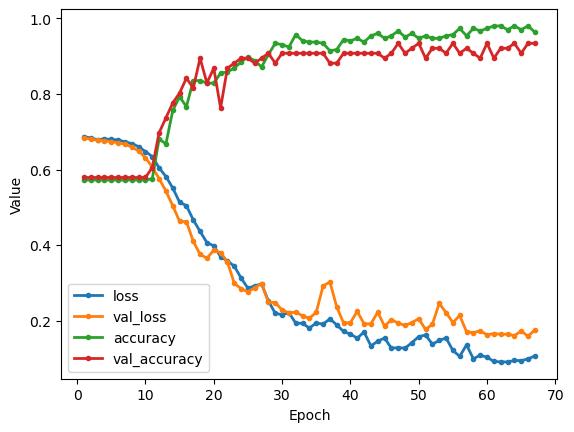

In [93]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [94]:
k = 4
X_train, y_train = build_kmer_representation(dataset, k=k)
X_test, y_test = build_kmer_representation(testset, k=k)
X_test.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.009124,0.006387,0.008212,0.011861,0.001825,0.000912,0.000912,0.004562,0.008212,0.004562,...,0.005474,0.012774,0.012774,0.007299,0.004562,0.011861,0.008212,0.013686,0.009124,0.021898
1,0.026341,0.015052,0.005644,0.010348,0.025400,0.007526,0.003763,0.010348,0.013170,0.005644,...,0.001881,0.006585,0.003763,0.000000,0.003763,0.005644,0.002822,0.003763,0.003763,0.002822
2,0.009129,0.005267,0.006671,0.010183,0.004916,0.003862,0.002107,0.004213,0.007725,0.007374,...,0.002107,0.009480,0.011587,0.004213,0.006671,0.009831,0.003511,0.009480,0.010183,0.012289
3,0.011401,0.004781,0.008827,0.008827,0.005885,0.005149,0.003310,0.002942,0.011033,0.006988,...,0.002207,0.011769,0.006252,0.004781,0.005149,0.009562,0.006620,0.007723,0.008827,0.012872
4,0.018010,0.006861,0.007719,0.010292,0.012436,0.004717,0.003859,0.004717,0.009434,0.005575,...,0.005146,0.010292,0.010292,0.003002,0.003859,0.012436,0.002144,0.009863,0.012436,0.005575


In [95]:
NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,009 (418.00 KB)

 Trainable params: 107,009 (418.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6108 - loss: 0.6919 - val_accuracy: 0.5789 - val_loss: 0.6877
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5792 - loss: 0.6876 - val_accuracy: 0.5789 - val_loss: 0.6831
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5476 - loss: 0.6881 - val_accuracy: 0.5789 - val_loss: 0.6802
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5400 - loss: 0.6886 - val_accuracy: 0.5789 - val_loss: 0.6776
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6012 - loss: 0.6704 - val_accuracy: 0.5789 - val_loss: 0.6753
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5847 - loss: 0.6710 - val_accuracy: 0.5789 - val_loss: 0.6721
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6057 - loss: 0.6683 - val_accuracy: 0.5789 - val_loss: 0.6685
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5391 - loss: 0.6806 - val_accuracy: 0.5789 - val_loss: 

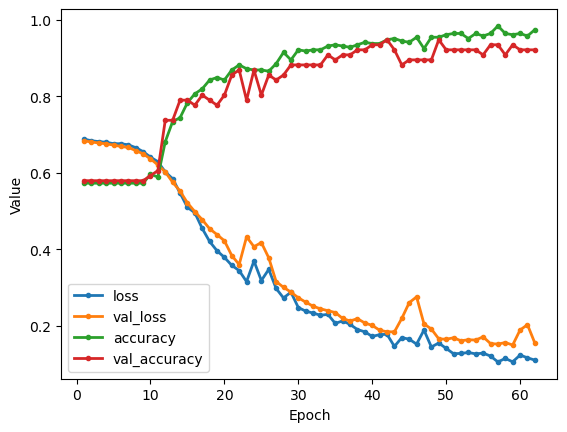

In [96]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [97]:
k = 5
X_train, y_train = build_kmer_representation(dataset, k=k)
X_test, y_test = build_kmer_representation(testset, k=k)
X_test.head()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.000913,0.002740,0.000913,0.004566,0.000913,0.000913,0.000913,0.003653,0.005479,0.000913,...,0.002740,0.006393,0.001826,0.000913,0.001826,0.004566,0.002740,0.006393,0.006393,0.006393
1,0.011299,0.005650,0.003766,0.005650,0.006591,0.001883,0.001883,0.004708,0.000942,0.002825,...,0.000942,0.000000,0.000942,0.000000,0.001883,0.000942,0.001883,0.000000,0.000942,0.000000
2,0.002459,0.002107,0.002107,0.002459,0.002107,0.000351,0.000702,0.002107,0.002459,0.002459,...,0.000702,0.003161,0.004215,0.001405,0.002107,0.002107,0.000702,0.004566,0.003512,0.003512
3,0.004415,0.001472,0.001472,0.004047,0.001840,0.000736,0.001472,0.000736,0.004047,0.002575,...,0.000736,0.003679,0.001840,0.001840,0.002208,0.002943,0.002943,0.003679,0.002943,0.003311
4,0.006435,0.003861,0.003003,0.004719,0.004719,0.000858,0.000429,0.000858,0.003003,0.002145,...,0.002574,0.004290,0.003861,0.001287,0.001716,0.005577,0.000429,0.002145,0.002145,0.000858


In [98]:
NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,617 (1.16 MB)

 Trainable params: 303,617 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5751 - loss: 0.6926 - val_accuracy: 0.5789 - val_loss: 0.6895
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5973 - loss: 0.6885 - val_accuracy: 0.5789 - val_loss: 0.6849
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5499 - loss: 0.6883 - val_accuracy: 0.5789 - val_loss: 0.6816
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5517 - loss: 0.6866 - val_accuracy: 0.5789 - val_loss: 0.6782
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5842 - loss: 0.6770 - val_accuracy: 0.5789 - val_loss: 0.6750
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5506 - loss: 0.6830 - val_accuracy: 0.5789 - val_loss: 0.6718
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5571 - loss: 0.6795 - val_accuracy: 0.5789 - val_loss: 0.6674
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5706 - loss: 0.6682 - val_accuracy: 0.5789 - val_loss:

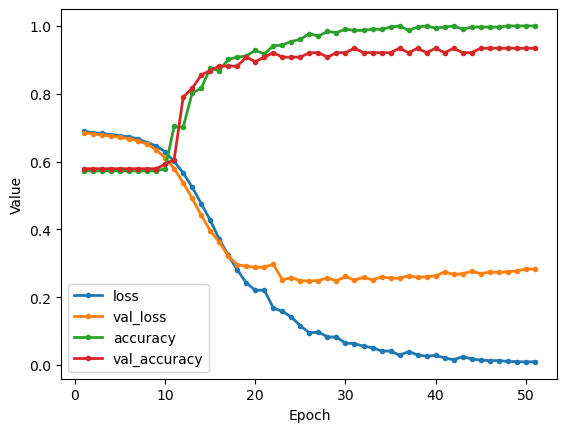

In [99]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=6</li></ul>
</h4>

In [100]:
k = 6
X_train, y_train = build_kmer_representation(dataset, k=k)
X_test, y_test = build_kmer_representation(testset, k=k)
X_test.head()

,AAAAAA,AAAAAC,AAAAAG,AAAAAT,AAAACA,AAAACC,AAAACG,AAAACT,AAAAGA,AAAAGC,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,0.000000,0.000914,0.000000,0.000000,0.000000,0.000914,0.000914,0.000914,0.000000,0.000914,...,0.001828,0.000914,0.001828,0.000914,0.001828,0.001828,0.000000,0.003656,0.001828,0.000914
1,0.006598,0.002828,0.000943,0.000943,0.003770,0.000943,0.000000,0.000943,0.000943,0.001885,...,0.000000,0.000000,0.000943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000351,0.001054,0.000351,0.000703,0.001054,0.000000,0.000351,0.000703,0.001405,0.000351,...,0.000000,0.002460,0.001405,0.000000,0.001405,0.000351,0.000351,0.000703,0.001405,0.001054
3,0.001472,0.001104,0.001104,0.000736,0.000736,0.000368,0.000368,0.000000,0.000368,0.000368,...,0.000000,0.002208,0.000736,0.000736,0.001104,0.000368,0.001104,0.001104,0.000736,0.000368
4,0.002146,0.001288,0.001288,0.001717,0.002146,0.000858,0.000429,0.000429,0.001717,0.000858,...,0.000429,0.000858,0.001288,0.000000,0.000858,0.000000,0.000000,0.000429,0.000429,0.000000


In [101]:
NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 4 : FEED-FORWARD NETWORKS</span>

Model: "FEEDFORWARD_k6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,049 (4.16 MB)

 Trainable params: 1,090,049 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5892 - loss: 0.6923 - val_accuracy: 0.5789 - val_loss: 0.6883
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5968 - loss: 0.6860 - val_accuracy: 0.5789 - val_loss: 0.6826
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5658 - loss: 0.6845 - val_accuracy: 0.5789 - val_loss: 0.6791
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5751 - loss: 0.6791 - val_accuracy: 0.5789 - val_loss: 0.6759
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5918 - loss: 0.6722 - val_accuracy: 0.5789 - val_loss: 0.6728
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5877 - loss: 0.6682 - val_accuracy: 0.5789 - val_loss: 0.6683
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5888 - loss: 0.6623 - val_accuracy: 0.5789 - val_loss: 0.6621
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5834 - loss: 0.6579 - val_accuracy: 0.5789 - val_loss:

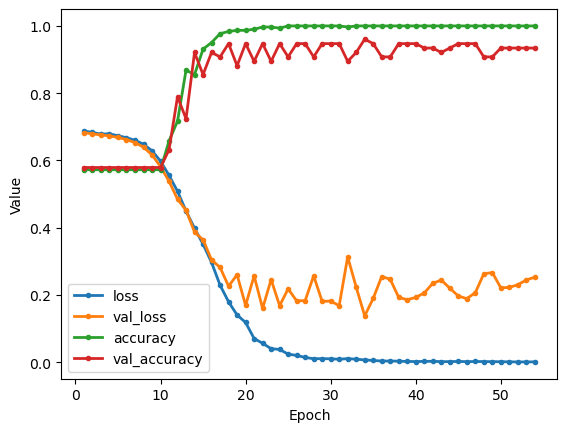

In [102]:
name="FEEDFORWARD_k6"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<div style="background-color: #80c4e6; padding: 0.5em;">
    <b>RECAP</b>: BEST MODEL FOUND
    
    * k = 6, acc: 96.05%
    
</div>

try tuning model

In [ ]:
**

In [ ]:
import keras_tuner

In [ ]:
name="FEEDFORWARD_k6"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential(name="SEARCH_ARCH")
    model.add(Input(shape=(SEQ_LENGTH,)))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["relu"]),
            )
        )
        model.add(Dropout(rate=0.3))
        #if hp.Boolean("dropout"):
        #model.add(tf.keras.layers.Dropout(
        #        rate=hp.Float('rate', min_value = 0.3, max_value = 0.5, step = 0.1),
        #    )
        #)

    # Keep last layers without tuning
    model.add(tf.keras.layers.Dense(NUM_CLASS, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Tune learning rate
    #model.compile(
    #    optimizer=tf.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=3e-3, max_value=0.2, sampling="linear")),
    #    loss="categorical_crossentropy",
    #    metrics=["accuracy"],
    #)
    return model

build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=400,
    executions_per_trial=1,
    overwrite=True,
    directory="/tmp/tb_logs",
    project_name="lab3_search",
)

# See summary
tuner.search_space_summary()

In [ ]:
stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=5,
    verbose=0,
)

# Start search
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    callbacks=[stop_callback, tf.keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

# Get the best model
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.build()
best_model.summary()

# Let's report the performance on test set
test_score = best_model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=32,
    verbose=False,
    return_dict=True
)
print(f"\nTUNED_MODEL_TESTSET(LOSS={test_score['loss']} and ACCURACY={test_score['accuracy']})\n")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs